# Gradient Boosted model with state and action vectors as a concatenated input

## Import Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pandas


In [2]:
import sys
import os

sys.path.append(os.path.abspath("../scripts"))

from load_data import load_data

## Load Data

### Start with smaller dataset

### 3/6/24 - A8 Channels from Selva
- **Number of Cycles**: ~50
- **Details**:
  - Channels: A1 to A8
  - High C-Rate
  - Room Temperature (25 °C)

In [3]:
df = load_data("03-06-24", "A1.csv")

## Preprocess

In [4]:
df = df.dropna()

# fix reading column issue
if "#NAME?" in df.columns.values : df = df.rename(columns={"#NAME?": "Im(Z)/Ohm"})

# Apply filtering
df = df.loc[(df['cycle number'] != 0)].copy()
# df = df.loc[(df['Ns'].isin([1, 6])) & (df['cycle number'] != 0)].copy()

In [5]:
df.columns.values

array(['mode', 'ox/red', 'error', 'control changes', 'Ns changes',
       'counter inc.', 'Ns', 'I Range', 'time/s', 'control/V/mA',
       'Ecell/V', 'I/mA', 'dq/mA.h', '(Q-Qo)/mA.h', '|Energy|/W.h',
       'freq/Hz', '|Z|/Ohm', 'Phase(Z)/deg', 'Q charge/discharge/mA.h',
       'half cycle', 'Energy charge/W.h', 'Energy discharge/W.h',
       'Capacitance charge/µF', 'Capacitance discharge/µF', 'step time/s',
       'z cycle', 'Re(Z)/Ohm', 'Im(Z)/Ohm', 'Re(Y)/Ohm-1', 'Im(Y)/Ohm-1',
       '|Y|/Ohm-1', 'Phase(Y)/deg', 'x', 'Q discharge/mA.h',
       'Q charge/mA.h', 'Capacity/mA.h', 'Efficiency/%', 'control/V',
       'control/mA', 'cycle number', 'P/W', 'R/Ohm'], dtype=object)

In [6]:
capacity = df['Capacity/mA.h']
cycle_number = df['cycle number']

### Confirm Degradation

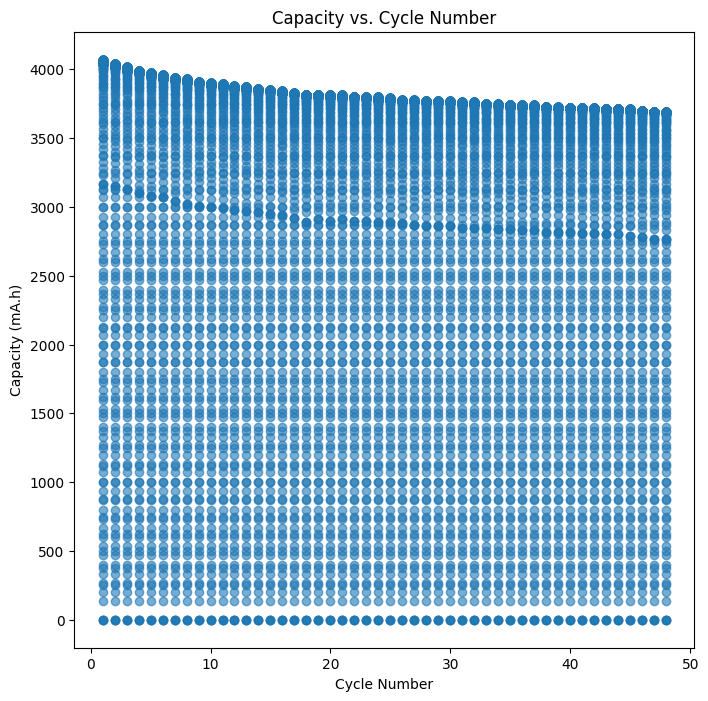

In [7]:
plt.figure(figsize=(8, 8))
plt.scatter(cycle_number, capacity, alpha=0.6)
plt.xlabel('Cycle Number')
plt.ylabel('Capacity (mA.h)')
plt.title('Capacity vs. Cycle Number')
plt.show()

#### Important note: degradation is not visible unless we filter for just the states that EIS is being performed

## Building the Input
### We need a state and action vector

### State Vector $s_{n}$ - concatenated impedance values at 57 different frequencies 0.02Hz - 20kHz

In [8]:
df['freq/Hz'].min()

np.float64(0.0)

In [9]:
df['freq/Hz'].max()

np.float64(10000.0)

### We don't have the same range of frequencies in our data. Our data ranges from 0Hz to 10kHz

### Must make state vector FOR EACH CYCLE

In [10]:
# Dictionary to store EIS state data by cycle number
eis_data_by_cycle = {}

# Get all unique cycle numbers
all_cycles = df['cycle number'].unique()

for cycle in sorted(all_cycles):
    # A) Subset the dataframe for this cycle
    df_cycle_data = df[df['cycle number'] == cycle].copy()
    
    # B) From within that cycle, filter only the EIS rows (Ns == 1 or 6)
    df_cycle_eis_data = df_cycle_data[df_cycle_data['Ns'].isin([1, 6])].copy()
    
    # If no EIS data for this cycle, store empty structures
    if df_cycle_eis_data.empty:
        eis_data_by_cycle[cycle] = {
            "labeled_impedance": {},
            "state_vector": np.array([])
        }
        continue

    # C) Sort by frequency (ascending) -- only makes sense for EIS rows
    df_cycle_eis_data.sort_values(by='freq/Hz', ascending=True, inplace=True)
    
    # D) Extract frequency, real part, and imaginary part
    freq_array = df_cycle_eis_data['freq/Hz'].values
    z_re_array = df_cycle_eis_data['Re(Z)/Ohm'].values
    z_im_array = df_cycle_eis_data['Im(Z)/Ohm'].values

    # E) Build a dictionary that labels each frequency's real/imag parts
    labeled_impedance = {}
    for i, freq in enumerate(freq_array):
        freq_str = f"{freq:.5g}"  # e.g. "0.01", "100", etc.
        labeled_impedance[f"Z_re({freq_str}Hz)"] = z_re_array[i]
        labeled_impedance[f"Z_im({freq_str}Hz)"] = z_im_array[i]

    # F) Create the flattened EIS state vector for ML
    #    [Z_re(w1), Z_im(w1), Z_re(w2), Z_im(w2), ..., Z_re(wN), Z_im(wN)]
    eis_state_vector = np.concatenate([z_re_array, z_im_array])

    # G) Store in a dictionary keyed by cycle
    eis_data_by_cycle[cycle] = {
        "labeled_impedance": labeled_impedance,
        "state_vector": eis_state_vector
    }


In [11]:
# Inspect first 2 cycles for sanity check
for cycle in sorted(eis_data_by_cycle.keys())[:2]:
    data_for_cycle = eis_data_by_cycle[cycle]
    labeled_dict = data_for_cycle["labeled_impedance"]
    eis_vec = data_for_cycle["state_vector"]
    
    print(f"\nCycle {cycle}:")
    print(f"  Number of labeled entries: {len(labeled_dict)}")
    
    # Print a few example labeled entries
    example_keys = list(labeled_dict.keys())[:6]
    
    for k in example_keys: print(f"    {k} = {labeled_dict[k]}")
    
    print ('\n')
    print(f"  State vector length = {len(eis_vec)}")
    print(f"  First 6 elements of state vector: {eis_vec[:6]}")


Cycle 1.0:
  Number of labeled entries: 160
    Z_re(0.00931Hz) = 0.0382
    Z_im(0.00931Hz) = 0.0607
    Z_re(0.014Hz) = 0.0382
    Z_im(0.014Hz) = 0.0431
    Z_re(0.0186Hz) = 0.0331
    Z_im(0.0186Hz) = 0.0341


  State vector length = 162
  First 6 elements of state vector: [0.0382 0.0382 0.0331 0.0327 0.0301 0.0281]

Cycle 2.0:
  Number of labeled entries: 160
    Z_re(0.00931Hz) = 0.0414
    Z_im(0.00931Hz) = 0.0571
    Z_re(0.014Hz) = 0.0363
    Z_im(0.014Hz) = 0.0432
    Z_re(0.0186Hz) = 0.0327
    Z_im(0.0186Hz) = 0.0315


  State vector length = 162
  First 6 elements of state vector: [0.0414 0.0363 0.0327 0.0316 0.0288 0.0273]


In [12]:
for cycle in sorted(eis_data_by_cycle.keys()):
      data_for_cycle = eis_data_by_cycle[cycle]
      eis_vec = data_for_cycle["state_vector"]
      print(f"Cycle {cycle}: {len(eis_vec)}")

Cycle 1.0: 162
Cycle 2.0: 162
Cycle 3.0: 162
Cycle 4.0: 162
Cycle 5.0: 162
Cycle 6.0: 162
Cycle 7.0: 162
Cycle 8.0: 162
Cycle 9.0: 162
Cycle 10.0: 162
Cycle 11.0: 162
Cycle 12.0: 162
Cycle 13.0: 162
Cycle 14.0: 162
Cycle 15.0: 162
Cycle 16.0: 162
Cycle 17.0: 162
Cycle 18.0: 162
Cycle 19.0: 162
Cycle 20.0: 162
Cycle 21.0: 162
Cycle 22.0: 162
Cycle 23.0: 162
Cycle 24.0: 162
Cycle 25.0: 162
Cycle 26.0: 162
Cycle 27.0: 162
Cycle 28.0: 162
Cycle 29.0: 162
Cycle 30.0: 162
Cycle 31.0: 162
Cycle 32.0: 162
Cycle 33.0: 162
Cycle 34.0: 162
Cycle 35.0: 162
Cycle 36.0: 162
Cycle 37.0: 162
Cycle 38.0: 162
Cycle 39.0: 162
Cycle 40.0: 162
Cycle 41.0: 162
Cycle 42.0: 162
Cycle 43.0: 162
Cycle 44.0: 162
Cycle 45.0: 162
Cycle 46.0: 162
Cycle 47.0: 162
Cycle 48.0: 66


## We will skip cycle 48 because it does not contain 162 element

### Action Vector building

### VERY IMPORTANT NOTES FOR NICK: filtering out NS= 1,6 is the EIS data which is good for building the state vector, however when building the action vector we would want all of the information 

In [13]:
action_data_by_cycle = {}

for cycle in sorted(all_cycles):
    # A) Subset for this cycle
    df_cycle_data = df[df['cycle number'] == cycle].copy()
    
    # B) Identify charge vs. discharge rows (Typically, positive I/mA = charge, negative = discharge)
    df_charge_data = df_cycle_data[df_cycle_data['I/mA'] > 0].copy()
    df_discharge_data = df_cycle_data[df_cycle_data['I/mA'] < 0].copy()
    
    # C) Compute features for Charge
    # 1) Average charge current
    i_charge_avg = df_charge_data['I/mA'].mean() if not df_charge_data.empty else 0.0
    
    # 2) Total charge time (s) - sum of "step time/s" while charging
    total_charge_time = df_charge_data['step time/s'].sum() if not df_charge_data.empty else 0.0
    
    # 3) Net charged capacity (mA.h)
    if not df_charge_data.empty:
        q_charge_start = df_charge_data['Q charge/mA.h'].min()
        q_charge_end   = df_charge_data['Q charge/mA.h'].max()
        q_charge = q_charge_end - q_charge_start
    else:
        q_charge = 0.0
    
    # D) Compute features for Discharge
    i_discharge_avg = df_discharge_data['I/mA'].mean() if not df_discharge_data.empty else 0.0
    total_discharge_time = df_discharge_data['step time/s'].sum() if not df_discharge_data.empty else 0.0
    
    if not df_discharge_data.empty:
        q_discharge_start = df_discharge_data['Q discharge/mA.h'].min()
        q_discharge_end   = df_discharge_data['Q discharge/mA.h'].max()
        q_discharge = q_discharge_end - q_discharge_start
    else:
        q_discharge = 0.0

    # E) Form the Action Vector
    # A simple 6-element vector with [charge stats, discharge stats]
    usage_action_vector = np.array([
        i_charge_avg,
        total_charge_time,
        q_charge,
        i_discharge_avg,
        total_discharge_time,
        q_discharge
    ], dtype=float)

    # F) Store in a dictionary keyed by cycle
    action_data_by_cycle[cycle] = usage_action_vector

In [14]:
# Inspect first 5 cycles
for cycle in sorted(action_data_by_cycle.keys())[:5]:
    print(f"Cycle {cycle} action vector: {action_data_by_cycle[cycle]}")


Cycle 1.0 action vector: [  3964.33533835 284990.002        4070.          -7188.436
 136720.002        4040.        ]
Cycle 2.0 action vector: [  3901.74740741 273740.002        4040.          -7389.30547945
 150798.002        4020.        ]
Cycle 3.0 action vector: [  3869.18059701 259690.002        4020.          -7290.18055556
 131776.002        4000.        ]
Cycle 4.0 action vector: [  3793.22386861 271260.002        3990.          -7587.94637681
 131636.002        3970.        ]
Cycle 5.0 action vector: [  3900.44829323 262410.002        3970.          -7182.59589041
 147306.002        3960.        ]


In [15]:
# eis_data_by_cycle[cycle] = {
#     "state_vector": np.array([...])  # EIS data
# }
# action_data_by_cycle[cycle] = np.array([...])  # usage stats

X = []  # Will hold combined [state + action] for each cycle
y = []  # Will hold the discharge capacity (target) for each cycle

# 1) Find cycles present in BOTH dictionaries
common_cycles = sorted(set(eis_data_by_cycle.keys()) & set(action_data_by_cycle.keys()))

# 2) Build combined X, y
for cycle in common_cycles:
    # -- A) EIS (state) vector
    state_vec = eis_data_by_cycle[cycle]["state_vector"]
    # Check if state vector has the correct dimension (162 in your example)
    if len(state_vec) != 162:
        print(f"Skipping cycle {cycle}: EIS vector length {len(state_vec)} != 162")
        continue
    
    # -- B) Action (usage) vector
    action_vec = action_data_by_cycle[cycle]
    
    # Combine [state_vec, action_vec] into one 1D array
    combined_input = np.concatenate([state_vec, action_vec])
    
    # -- C) Fetch the target capacity Q_n from the original dataframe
    df_cycle = df[df['cycle number'] == cycle]
    if df_cycle.empty:
        # No data for this cycle in df, skip
        print(f"Skipping cycle {cycle}: no rows in df.")
        continue
    
    # Use your chosen approach for the "target." 
    # Example: the maximum Q discharge for that cycle
    Q_n = df_cycle['Q discharge/mA.h'].max()
    if np.isnan(Q_n):
        print(f"Skipping cycle {cycle}: Q_n is NaN.")
        continue
    
    # -- D) Store in final X, y
    X.append(combined_input)
    y.append(Q_n)

# 3) Convert lists to NumPy arrays
X = np.array(X)
y = np.array(y)

print("Final dataset shapes:")
print("  X:", X.shape)
print("  y:", y.shape)


Skipping cycle 48.0: EIS vector length 66 != 162
Final dataset shapes:
  X: (47, 168)
  y: (47,)


## Algorithm and Model

In [16]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split

# Suppose X, y are your features and targets
# X.shape -> (num_samples, num_features)
# y.shape -> (num_samples,)

num_ensemble = 10
models = []

for i in range(num_ensemble):
    # Create a new GB regressor with hyperparameters similar to the paper
    # (500 estimators, max_depth=100). You can tweak "subsample", "learning_rate", etc.
    gb_model = GradientBoostingRegressor(
        n_estimators=500,
        max_depth=100,
        # You can tune these to avoid overfitting:
        # subsample=0.8,
        # learning_rate=0.1,
        random_state=42 + i  # different seed per model
    )
    models.append(gb_model)


In [17]:
# Let's do a simple train/test split to demonstrate
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Train each model
for m in models:
    m.fit(X_train, y_train)

# Predictions from each model
preds_ensemble = [m.predict(X_test) for m in models]

# Convert list of arrays to a 2D array: shape = (num_models, num_samples_test)
preds_ensemble = np.array(preds_ensemble)

# Mean prediction across ensemble: shape = (num_samples_test,)
y_pred_mean = np.mean(preds_ensemble, axis=0)

# Standard deviation across ensemble: shape = (num_samples_test,)
y_pred_std = np.std(preds_ensemble, axis=0)



In [18]:
# Evaluate
r2 = r2_score(y_test, y_pred_mean)
mae = mean_absolute_error(y_test, y_pred_mean)

print("Ensemble R^2 Score:", r2)
print("Ensemble MAE:", mae)
print("Predictions shape:", y_pred_mean.shape)
print("Uncertainty shape (std):", y_pred_std.shape)


Ensemble R^2 Score: 0.9708081610217588
Ensemble MAE: 10.56825929077586
Predictions shape: (10,)
Uncertainty shape (std): (10,)


### Attempting to test the model against other datasets

In [19]:
import joblib

# Suppose you have your list of models: models = [model1, model2, ... model10]
joblib.dump(models, "../models/gb_ensemble.pkl")

['../models/gb_ensemble.pkl']

In [24]:
# 1) Import your custom preprocessing functions
from state_and_action_vector_preprocess import (
    build_eis_data_by_cycle,
    build_action_data_by_cycle,
    build_combined_dataset
)

# 2) Load your new dataset into a DataFrame (example function call)
df = load_data("03-06-24", "A2.csv")  # or pd.read_csv("some_new_file.csv")

# 3) Build EIS data, action data, then combine to (X, y)
eis_dict = build_eis_data_by_cycle(df)
action_dict = build_action_data_by_cycle(df)
X, y = build_combined_dataset(
    df,
    eis_data_by_cycle=eis_dict,
    action_data_by_cycle=action_dict,
    expected_eis_dim=162  # Adjust if your EIS dimension is different
)

print("X shape:", X.shape)
print("y shape:", y.shape)


Skipping cycle 0.0: EIS vector length 258 != 162
Skipping cycle 48.0: EIS vector length 66 != 162
Final dataset shapes:
  X: (47, 168)
  y: (47,)
X shape: (47, 168)
y shape: (47,)


In [ ]:
# 4) Load your ensemble of models from the .pkl file
models = joblib.load("../models/gb_ensemble.pkl")
# 'models' should be a list of 10 GradientBoostingRegressor objects

In [25]:
# 5) Use the ensemble to predict on X
#    For each model, predict on X, then collect results
preds_ensemble = [model.predict(X) for model in models]  # list of arrays
preds_ensemble = np.array(preds_ensemble)                # shape = (num_models, num_samples)

# 6) Compute the mean and std across the ensemble for each sample
y_pred_mean = np.mean(preds_ensemble, axis=0)
y_pred_std  = np.std(preds_ensemble, axis=0)

# 7) Evaluate or inspect predictions
print("Mean predictions:", y_pred_mean)
print("Prediction std:", y_pred_std)

# If you have ground truth y for these new data, you can evaluate error:
from sklearn.metrics import r2_score, mean_absolute_error

r2 = r2_score(y, y_pred_mean)
mae = mean_absolute_error(y, y_pred_mean)

print("R^2 on new data:", r2)
print("MAE on new data:", mae)


Mean predictions: [4022.98778593 4001.00900741 3997.31829702 3994.28413139 3924.9968807
 3922.78422785 3909.56445202 3894.12530034 3893.48326188 3888.05368268
 3867.2949048  3894.63468362 3842.70254471 3842.45555764 3835.23230461
 3789.35213077 3784.82731985 3785.32398791 3780.73444595 3782.62188255
 3772.08110166 3773.3098339  3770.8936128  3770.99336185 3772.09272056
 3747.01359251 3747.1229191  3747.12129587 3748.99669781 3748.88202801
 3747.44775516 3741.59698236 3741.37819603 3737.91195258 3741.37110649
 3738.60117836 3725.41543146 3726.57470869 3724.84254757 3721.26875006
 3723.27083098 3719.85606418 3720.35284864 3720.99575674 3721.22687229
 3703.15458519 3695.33912655]
Prediction std: [ 5.492215    6.02349396  5.523526    4.91710666  7.54183076  5.86907401
  3.24844305  5.10748003  5.4117505   8.62427264  2.92484877  1.27093476
 12.12104707 11.59463584  9.21043289  8.06630485  8.65949379  8.02882772
  5.99941532  7.20568235  5.30604917  6.53677445  5.16417359  5.57222032
  5.70

In [ ]:
# 2) Load your new dataset into a DataFrame (example function call)
df = load_data("03-22-24", "A1.csv")  # or pd.read_csv("some_new_file.csv")

In [32]:
df = df.dropna()

# fix reading column issue
if "#NAME?" in df.columns.values : df = df.rename(columns={"#NAME?": "Im(Z)/Ohm"})

In [33]:
df.columns.values

array(['mode', 'ox/red', 'error', 'control changes', 'Ns changes',
       'counter inc.', 'Ns', 'I Range', 'time/s', 'control/V/mA',
       'Ecell/V', 'I/mA', 'dq/mA.h', '(Q-Qo)/mA.h', '|Energy|/W.h',
       'freq/Hz', '|Z|/Ohm', 'Phase(Z)/deg', 'Q charge/discharge/mA.h',
       'half cycle', 'Energy charge/W.h', 'Energy discharge/W.h',
       'Capacitance charge/µF', 'Capacitance discharge/µF', 'step time/s',
       'z cycle', 'Re(Z)/Ohm', 'Im(Z)/Ohm', 'Re(Y)/Ohm-1', 'Im(Y)/Ohm-1',
       '|Y|/Ohm-1', 'Phase(Y)/deg', 'x', 'Q discharge/mA.h',
       'Q charge/mA.h', 'Capacity/mA.h', 'Efficiency/%', 'control/V',
       'control/mA', 'cycle number', 'P/W', 'R/Ohm'], dtype=object)

In [34]:
# 3) Build EIS data, action data, then combine to (X, y)
eis_dict = build_eis_data_by_cycle(df)
action_dict = build_action_data_by_cycle(df)
X, y = build_combined_dataset(
    df,
    eis_data_by_cycle=eis_dict,
    action_data_by_cycle=action_dict,
    expected_eis_dim=162  # Adjust if your EIS dimension is different
)

print("X shape:", X.shape)
print("y shape:", y.shape)


Skipping cycle 0.0: EIS vector length 258 != 162
Skipping cycle 157.0: EIS vector length 66 != 162
Final dataset shapes:
  X: (156, 168)
  y: (156,)
X shape: (156, 168)
y shape: (156,)


In [35]:
# 5) Use the ensemble to predict on X
#    For each model, predict on X, then collect results
preds_ensemble = [model.predict(X) for model in models]  # list of arrays
preds_ensemble = np.array(preds_ensemble)                # shape = (num_models, num_samples)

# 6) Compute the mean and std across the ensemble for each sample
y_pred_mean = np.mean(preds_ensemble, axis=0)
y_pred_std  = np.std(preds_ensemble, axis=0)

# 7) Evaluate or inspect predictions
print("Mean predictions:", y_pred_mean)
print("Prediction std:", y_pred_std)

# If you have ground truth y for these new data, you can evaluate error:
from sklearn.metrics import r2_score, mean_absolute_error

r2 = r2_score(y, y_pred_mean)
mae = mean_absolute_error(y, y_pred_mean)

print("R^2 on new data:", r2)
print("MAE on new data:", mae)


Mean predictions: [4039.99999996 4019.99999998 3999.99999998 3979.99999999 3977.68434219
 3939.99999999 3929.99999999 3909.99999999 3899.99999999 3890.
 3901.49222038 3861.09205821 3859.99999999 3850.         3840.
 3830.         3820.         3810.         3789.9084303  3800.
 3800.         3800.         3786.7974594  3790.         3780.
 3780.         3770.         3770.         3760.61088677 3760.
 3767.84141964 3759.65036067 3750.         3741.82385335 3740.
 3740.         3730.         3730.         3730.         3720.00000001
 3720.00000001 3710.00000002 3701.97483548 3710.00000002 3700.00000002
 3700.00000002 3690.00000005 3698.01056954 3697.37486813 3704.90203826
 3699.05543479 3701.06930316 3704.61891939 3705.12135292 3694.16008201
 3690.46391851 3690.7313116  3690.51085924 3704.84231382 3697.97561442
 3697.75493152 3690.70783079 3694.38366053 3690.80066926 3693.91060526
 3696.02562934 3690.751616   3690.7898664  3697.87275807 3698.03804227
 3690.60704258 3698.75616464 3690.65